# Model contents

Reproduces Fig. 2 and Fig. S1 of Zakhartsev et al. "SALARECON connects the Atlantic salmon genome to growth and feed efficiency" (2021).

In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import join
from collections import defaultdict
from matplotlib import rcParams
from scipy.stats import linregress

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
plot_dir = '../../figures'
data_path = '../../data'
model_path = f'{data_path}/models'
sasa_path = '../../salarecon.xml'

In [2]:
# Load SALARECON
model = cobra.io.read_sbml_model(sasa_path)

Academic license - for non-commercial use only - expires 2022-09-29
Using license file c:\gurobi912\gurobi.lic


In [3]:
# Load automatically generated KEGG model
kegg = cobra.io.read_sbml_model(f'{model_path}/sasa/auto/sasa_autokeggrec.xml')
kegg

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


<Model COBRAModel at 0x1e7e8be2cc0>

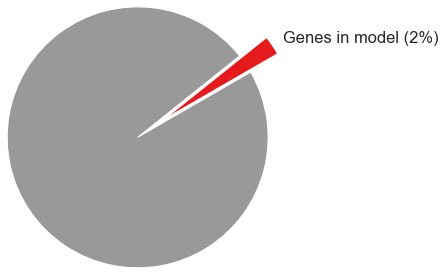

In [4]:
# Plot genome coverage pie chart
sns.set(font_scale=1.5, style='ticks')
f = plt.figure()

genes = 47329
model_genes = len(model.genes)

labels = ['Genes in model ({:.0f}%)'.format(100 * model_genes / genes), '']
x = [model_genes, genes - model_genes]
explode = [0, 0.5]
palette = ['#e41a1c', '#999999']

ax = plt.pie(x, explode=explode, labels=labels, colors=palette, radius=2, startangle=30)

sns.despine()
f.set_size_inches(10, 3)
f.savefig(join(plot_dir, 'genome_coverage_pie.svg'), bbox_inches='tight')

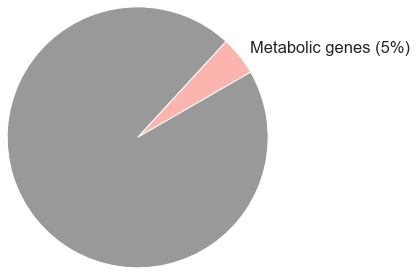

In [5]:
# Plot genome coverage pie chart
sns.set(font_scale=1.5, style='ticks')
f = plt.figure()

genes = 47329
model_genes = len([g for g in kegg.genes if g.reactions])

labels = ['Metabolic genes ({:.0f}%)'.format(100 * model_genes / genes), '']
x = [model_genes, genes - model_genes]
explode = [0, 0]
palette = ['#fbb4ae', '#999999']

ax = plt.pie(x, explode=explode, labels=labels, colors=palette, radius=2, startangle=30)

sns.despine()
f.set_size_inches(10, 3)
f.savefig(join(plot_dir, 'genome_coverage_pie_kegg.svg'), bbox_inches='tight')

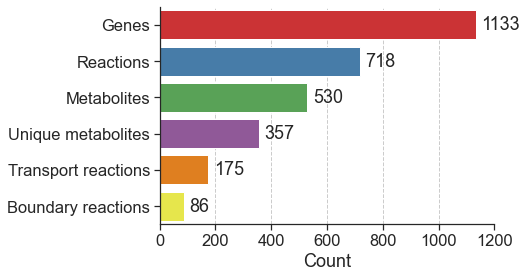

In [6]:
# Plot gene, reaction, and metabolite counts
sns.set(font_scale=1.5, style='ticks')
f = plt.figure()

y = ['Genes', 'Reactions', 'Metabolites', 'Unique metabolites', 'Transport reactions', 'Boundary reactions',]
x = [len(model.genes), len(model.reactions), len(model.metabolites), len(set(m.id[:-2] for m in model.metabolites)),
     len([r for r in model.reactions if len(set(m.compartment for m in r.metabolites)) > 1]), len(model.boundary)]

ax = sns.barplot(x=x, y=y, palette='Set1')
plt.grid(True, ls='--', axis='x')
plt.xlabel('Count')
plt.xlim(0, 1200)

for i in range(len(x)):
    plt.text(x[i] + 20, i, x[i], va='center')

sns.despine()
f.set_size_inches(6, 4)
f.savefig(join(plot_dir, 'model_count.svg'), bbox_inches='tight')

In [7]:
# Get reaction and metabolite counts by compartment
d = defaultdict(list)

for m in model.metabolites:
    c = m.compartment
    d['entity'].append('metabolite')
    d['compartment'].append(c)
    d['id'].append(m.id)

for r in model.reactions:
    compartments = set(m.compartment for m in r.metabolites)
    
    if r.boundary:
        e = 'boundary'
    elif len(compartments) > 1:
        e = 'transport'
    else:
        e = 'metabolic'

    for c in compartments:
        d['entity'].append('reaction')
        d['compartment'].append(c)
        d['id'].append(r.id)
        if r.boundary:
            d['entity'].append('boundary')
            d['compartment'].append(c)
            d['id'].append(r.id)
        elif len(compartments) > 1:
            d['entity'].append('transport')
            d['compartment'].append(c)
            d['id'].append(r.id)
        
comp_df = pd.DataFrame(d)
comp_df.loc[comp_df.compartment == 'i', 'compartment'] = 'm'
comp_df

entity compartment                     id
0     metabolite           e                  adn_e
1     metabolite           e                  but_e
2     metabolite           e                 chol_e
3     metabolite           e                creat_e
4     metabolite           e                 cytd_e
...          ...         ...                    ...
1854    reaction           c            RNA_biomass
1855    reaction           c         Lipids_biomass
1856    reaction           c        Protein_biomass
1857    reaction           c  Carbohydrates_biomass
1858    reaction           c                Biomass

[1859 rows x 3 columns]

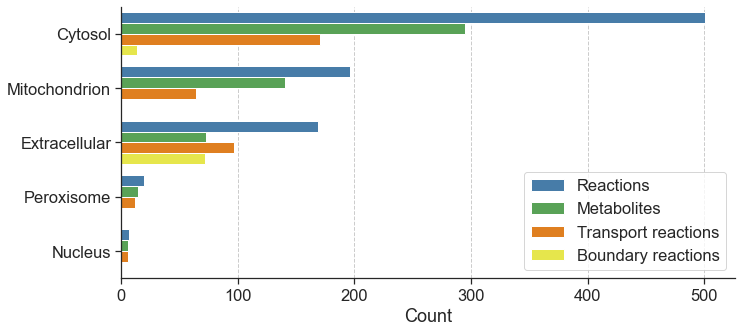

In [8]:
# Plot reaction and metabolite counts by compartment
sns.set(style='ticks', font_scale=1.5)

f = plt.figure()

order = ['c', 'm', 'e', 'x', 'n']
hue_order = ['reaction', 'metabolite', 'transport', 'boundary']

ax = sns.countplot(y='compartment', hue='entity', data=comp_df, palette=['#377eb8', '#4daf4a', '#ff7f00', '#ffff33'], order=order, hue_order=hue_order)

ax.set_yticklabels([model.compartments[x.get_text()].split(' ')[0].capitalize() for x in ax.get_yticklabels()])
ax.legend(['Reactions', 'Metabolites', 'Transport reactions', 'Boundary reactions'], title=None, loc='lower right')
plt.xlabel('Count')
plt.ylabel('')
plt.grid(ls='--', axis='x')

sns.despine()
f.set_size_inches(11, 5)
f.savefig(join(plot_dir, 'model_count_comp.svg'), bbox_inches='tight')

In [9]:
# Get transported metabolite counts by compartment
d = defaultdict(set)
for r in model.reactions:
    c = set(m.compartment for m in r.metabolites)
    if len(c) > 1 and not 'i' in c:
        c.discard('c')
        c = c.pop()
        d[model.compartments[c][0].capitalize()] |= set([m.id[:-2] for m in 
                                                         r.metabolites if m.compartment == c])
s = pd.Series(dict([(c, len(x)) for c, x in d.items()])).sort_values(ascending=False)

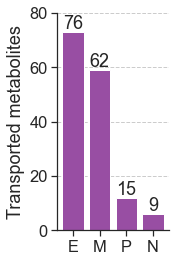

In [10]:
# Plot transported metabolite counts by compartment
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

plt.bar(x=s.index, height=s.values, color='#984ea3')

x = s.index
y = s.values
for i in range(len(y)):
    dy = 3
    plt.text(x[i], y[i] + dy, y[i] + dy, va='center', ha='center')

plt.ylabel('Transported metabolites')
plt.ylim(0, 80)
plt.yticks(np.arange(0, 90, 20))
plt.grid(True, ls='--', axis='y')

sns.despine()
f.set_size_inches(2, 4)
f.savefig(join(plot_dir, 'transport_count_comp.svg'), bbox_inches='tight')

In [11]:
# Determine fractional composition of macromolecules in biomass

# Biomass coefficients (mg / gDW)
# Source: https://onlinelibrary.wiley.com/doi/epdf/10.1111/anu.12194
comp = pd.Series({'Protein': 17.6, 'Lipids': 15.3, 'Ash': 1.69, 'Total': 35.2})
comp['Other'] = comp.Total - comp.Lipids - comp.Protein - comp.Ash

# Divide remaining (non-ash) biomass among DNA, RNA, and carbohydrates according to percentages from human biomass
# Source: Supplementary of Thiele et al. “A community-driven global reconstruction of human metabolism”.
frac = pd.Series({'DNA': 1.4, 'RNA': 5.8, 'Carbohydrates': 7.1})
frac /= frac.sum()
comp['DNA'] = comp.Other * frac.DNA
comp['RNA'] = comp.Other * frac.RNA
comp['Carbohydrates'] = comp.Other * frac.Carbohydrates

# Scale to 1 gDW
comp /= comp.Total
comp

Protein          0.500000
Lipids           0.434659
Ash              0.048011
Total            1.000000
Other            0.017330
DNA              0.001697
RNA              0.007029
Carbohydrates    0.008604
dtype: float64

No handles with labels found to put in legend.
C:\NMBU\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


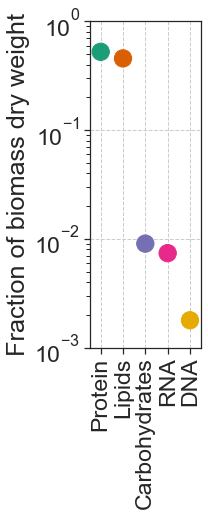

In [12]:
# Plot biomass fractions
sns.set(font_scale=2.1, style='ticks')
f, ax = plt.subplots()

labels = ['Protein', 'Lipids', 'Carbohydrates','RNA', 'DNA']
palette = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#e6ab02']
data = comp[labels] / comp[labels].sum()

# plt.bar(x=labels, height=data, color=palette, width=0.2, linewidth=0)
plt.scatter(x=labels, y=data, c=palette, s=300, zorder=2)
plt.yscale('log')
plt.xlim(-0.5, 4.5)
plt.ylim(1e-3, 1)
plt.grid(True, ls='--')
plt.ylabel('Fraction of biomass dry weight')
plt.legend().set_visible(False)
ax.set_xticklabels(labels, rotation=90)

f.set_size_inches(2, 6)
f.savefig(join(plot_dir, 'biomass_frac.svg'), bbox_inches='tight')

In [13]:
# Get biomass coefficients
d = defaultdict(list)
for x in ('Protein', 'Lipids', 'Carbohydrates', 'RNA', 'DNA'):
    r = model.reactions.get_by_id(x + '_biomass')
    for m in r.reactants:
        d['metabolite'].append(m.name.split(' ')[0].split('(')[0] + ' (' + x + ')')
        d['coefficient'].append(r.metabolites[m] * comp[x])
        d['component'].append(x)
        d['model'].append('SALARECON')
bm_df = pd.DataFrame(d).sort_values(by='coefficient', ascending=True)
bm_df.metabolite = bm_df.metabolite.str.replace('H2O', 'Water').str.replace('DATP', 'dATP').str.replace('DCTP', 'dCTP').str.replace('DGTP', 'dGTP').str.replace('DTTP', 'dTTP').str.replace('L-', '').str.replace('Phosphatidylcholine', 'PC')
bm_df = bm_df.sort_values(by='coefficient', ascending=False)
bm_df.to_csv(f'{data_path}/salarecon_biomass.csv')
bm_df

metabolite  coefficient      component      model
30                dGTP (DNA)    -0.001209            DNA  SALARECON
29                dCTP (DNA)    -0.001209            DNA  SALARECON
31                dTTP (DNA)    -0.001546            DNA  SALARECON
28                dATP (DNA)    -0.001546            DNA  SALARECON
26                 GTP (RNA)    -0.003588            RNA  SALARECON
27                 UTP (RNA)    -0.005824            RNA  SALARECON
24                 ATP (RNA)    -0.006292            RNA  SALARECON
25                 CTP (RNA)    -0.006416            RNA  SALARECON
5         Cysteine (Protein)    -0.007503        Protein  SALARECON
19      Tryptophan (Protein)    -0.030012        Protein  SALARECON
23  Glycogen (Carbohydrates)    -0.053066  Carbohydrates  SALARECON
14      Methionine (Protein)    -0.054495        Protein  SALARECON
10       Histidine (Protein)    -0.070686        Protein  SALARECON
20        Tyrosine (Protein)    -0.109386        Protein  SALARECON
2       Asparagine (Protein)    -0.109386        Protein  SALARECON
6        Glutamine (Protein)    -0.112545        Protein  SALARECON
15   Phenylalanine (Protein)    -0.143741        Protein  SALARECON
1         Arginine (Protein)    -0.172569        Protein  SALARECON
16         Proline (Protein)    -0.176913        Protein  SALARECON
17          Serine (Protein)    -0.198237        Protein  SALARECON
18       Threonine (Protein)    -0.204555        Protein  SALARECON
11      Isoleucine (Protein)    -0.206924        Protein  SALARECON
21          Valine (Protein)    -0.283929        Protein  SALARECON
13          Lysine (Protein)    -0.306438        Protein  SALARECON
8          Glycine (Protein)    -0.310782        Protein  SALARECON
12         Leucine (Protein)    -0.317100        Protein  SALARECON
3        Aspartate (Protein)    -0.318285        Protein  SALARECON
7        Glutamate (Protein)    -0.323813        Protein  SALARECON
0          Alanine (Protein)    -0.491643        Protein  SALARECON
22               PC (Lipids)    -0.592147         Lipids  SALARECON
9            Water (Protein)   -18.782627        Protein  SALARECON
4              ATP (Protein)   -18.782627        Protein  SALARECON

C:\NMBU\Miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


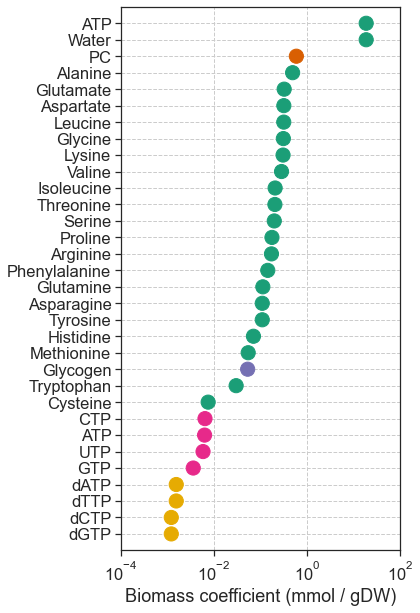

In [14]:
# Plot biomass coefficients
sns.set(style='ticks', font_scale=1.5)
f, ax = plt.subplots()
plt.xscale('log')
colors = dict(zip(labels, palette))
plt.scatter(y=bm_df.metabolite, x=bm_df.coefficient.abs(), s=200, c=[colors[x] for x in bm_df.component])
ax.set_yticklabels([x.split(' ')[0] for x in bm_df.metabolite])
plt.xlim(1e-4, 1e2)
plt.ylim(-1, len(bm_df))
plt.grid(True, ls='--')
plt.xlabel('Biomass coefficient (mmol / gDW)')
plt.ylabel('')
# sns.despine()
f.set_size_inches(5, 10)
f.savefig(join(plot_dir, 'biomass_comp.svg'), bbox_inches='tight')

In [15]:
# Count genes and metabolites associated with reactions
d = defaultdict(list)
for r in model.reactions:
    if r.boundary:
        d['class'].append('boundary')
    elif 'biomass' in r.id.lower():
        d['class'].append('biomass')
    elif len(set(m.compartment for m in r.metabolites)) > 1:
        d['class'].append('transport')
    else:
        d['class'].append('metabolic')
    d['id'].append(r.id)
    d['genes'].append(len(r.genes))
    d['metabolites'].append(len(r.metabolites))
cnt_df = pd.DataFrame(d)
cnt_df

class                     id  genes  metabolites
0    boundary               EX_adn_e      0            1
1    boundary               EX_but_e      0            1
2    boundary              EX_chol_e      0            1
3    boundary             EX_creat_e      0            1
4    boundary              EX_cytd_e      0            1
..        ...                    ...    ...          ...
713   biomass            RNA_biomass      0            6
714   biomass         Lipids_biomass      0            2
715   biomass        Protein_biomass      0           26
716   biomass  Carbohydrates_biomass      0            2
717   biomass                Biomass      0            5

[718 rows x 4 columns]

In [16]:
# Get number of genes by reaction class
df = cnt_df[cnt_df['class'] != 'biomass'].groupby('class').genes.value_counts().reset_index(name='count').pivot(index='genes', columns='class', values='count').fillna(0)
df = df[['metabolic', 'transport', 'boundary']]

cutoff = 10
df.loc[cutoff, :] = df[df.index >= cutoff].sum()
df = df.drop([x for x in df.index if x > cutoff])

df

class  metabolic  transport  boundary
genes                                
0           36.0       96.0      86.0
1           98.0        6.0       0.0
2           97.0       25.0       0.0
3           71.0       10.0       0.0
4           54.0        7.0       0.0
5           24.0        1.0       0.0
6           16.0        4.0       0.0
7           18.0        5.0       0.0
8           12.0        7.0       0.0
9            5.0        1.0       0.0
10          20.0       13.0       0.0

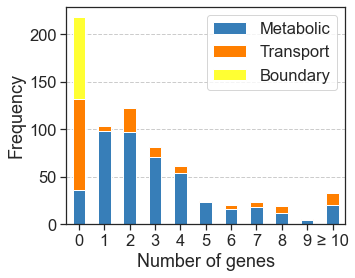

In [17]:
# Plot gene count distribution
sns.set(style='ticks', font_scale=1.5)
f, ax = plt.subplots()

df.plot(kind='bar', stacked=True, color=['#377eb8', '#ff7f00', '#ffff33'], ax=ax)

plt.grid(True, ls='--', axis='y')

plt.xlabel('Number of genes')
# plt.ylabel('Number of reactions')
plt.ylabel('Frequency')

xtl = [x.get_text() for x in ax.get_xticklabels()]
xtl[-1] = '≥ ' + xtl[-1]
ax.set_xticklabels(xtl, rotation=0)

h, l = ax.get_legend_handles_labels()
plt.legend([x.capitalize() for x in l], title=False)

f.set_size_inches(5, 4)
f.savefig(join(plot_dir, 'gene_counts.svg'), bbox_inches='tight')

In [18]:
# Get number of metabolites by reaction class
df = cnt_df[cnt_df['class'] != 'biomass'].groupby('class').metabolites.value_counts().reset_index(name='count').pivot(index='metabolites', columns='class', values='count').fillna(0)
df = df[['metabolic', 'transport', 'boundary']]

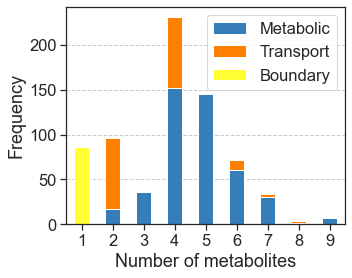

In [19]:
# Plot metabolite count distribution
sns.set(style='ticks', font_scale=1.5)
f, ax = plt.subplots()

df.plot(kind='bar', stacked=True, color=['#377eb8', '#ff7f00', '#ffff33'], ax=ax)

plt.grid(True, ls='--', axis='y')

plt.xlabel('Number of metabolites')
# plt.ylabel('Number of reactions')
plt.ylabel('Frequency')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

h, l = ax.get_legend_handles_labels()
plt.legend([x.capitalize() for x in l], title=False)

f.set_size_inches(5, 4)
f.savefig(join(plot_dir, 'metabolite_counts.svg'), bbox_inches='tight')

In [20]:
# Count reactions associated with genes
gc = defaultdict(int)
for g in model.genes:
    gc[len(g.reactions)] += 1
gc

defaultdict(int,
            {2: 224,
             1: 749,
             3: 68,
             4: 36,
             6: 10,
             7: 13,
             10: 3,
             11: 4,
             8: 11,
             5: 7,
             9: 4,
             15: 4})

In [21]:
# Count reactions associated with metabolites
mc = defaultdict(int)
for m in model.metabolites:
    mc[len(m.reactions)] += 1
mc

defaultdict(int,
            {2: 279,
             6: 18,
             4: 52,
             7: 16,
             3: 79,
             32: 4,
             14: 1,
             87: 1,
             120: 1,
             200: 1,
             23: 5,
             31: 1,
             78: 1,
             16: 2,
             15: 1,
             25: 2,
             18: 2,
             20: 1,
             12: 3,
             27: 2,
             8: 8,
             17: 3,
             10: 4,
             30: 1,
             5: 26,
             9: 7,
             67: 1,
             64: 1,
             11: 4,
             13: 2,
             38: 1})

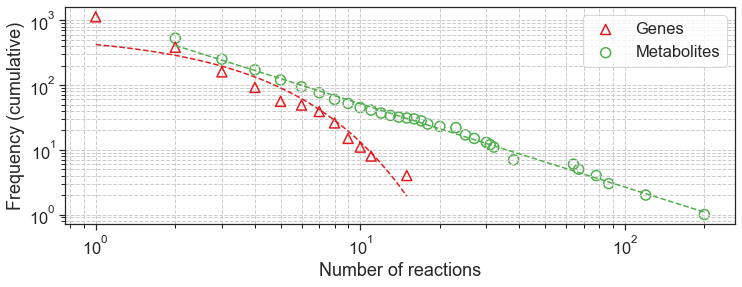

In [22]:
# Plot reaction count distributions
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

lw = 1.5
size = 100

x = sorted(gc.keys())
y = [gc[i] for i in x]
y = np.cumsum(y[::-1])[::-1]
plt.scatter(x, y, ec='#e41a1c', fc='none', s=size, marker='^', label='Genes', lw=lw)

a, b, r, p, s = linregress(x, np.log10(y))
xfit = np.linspace(np.min(x), np.max(x), 100)
yfit = a * xfit + b
plt.plot(xfit, 10 ** yfit, c='#e41a1c', ls='--', lw=lw)

x = sorted(mc.keys())
y = [mc[i] for i in x]
y = np.cumsum(y[::-1])[::-1]
plt.scatter(x, y, ec='#4daf4a', fc='none', s=size, zorder=0, label='Metabolites', lw=lw)

a, b, r, p, s = linregress(np.log10(x), np.log10(y))
xfit = np.log10([np.min(x), np.max(x)])
yfit = a * xfit + b
plt.plot(10 ** xfit, 10 ** yfit, c='#4daf4a', ls='--', lw=lw)

plt.legend()

plt.xlabel('Number of reactions')
plt.ylabel('Frequency (cumulative)')
# plt.xlabel('$k$')
# plt.ylabel('$P(K\geq k)$')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', which='both')

f.set_size_inches(12, 4)
f.savefig(join(plot_dir, 'reaction_counts.svg'), bbox_inches='tight')